# Hyperparameter Tuning Your Own R Algorithm with Your Own Container in Amazon SageMaker
_**Using Amazon SageMaker's Hyperparameter Tuning with a customer Docker container and R algorithm**_

---

**Read before running the notebook:**
- This notebook has been updated to SageMaker v2.0
- Use Python3 kernel for this notebook.
- Dockerfile has been updated to use [Amazon ECR Public Gallery](https://docs.aws.amazon.com/AmazonECR/latest/public/public-gallery.html)


## Contents

1. [Background](#Background)
1. [Setup](#Setup)
  1. [Permissions](#Permissions)
1. [Code](#Code)
  1. [Publish](#Publish)
1. [Data](#Data)
1. [Tune](#Tune)
1. [HPO Analysis](#HPO-Analysis)
1. [Host](#Host)
1. [Predict](#Predict)
1. [(Optional) Clean-up](#(Optional)-Clean-up)
1. [Wrap-up](#Wrap-up)

---
## Background

R is a popular open source statistical programming language, with a lengthy history in Data Science and Machine Learning.  The breadth of algorithms available as R packages is impressive and fuels a diverse community of users.  In this example, we'll combine one of those algorithms ([Multivariate Adaptive Regression Splines](https://en.wikipedia.org/wiki/Multivariate_adaptive_regression_splines)) with SageMaker's hyperparameter tuning capabilities to build a simple model on the well-known [Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). 


This notebook will focus mainly on the integration of hyperparameter tuning and a custom algorithm container, as well as hosting the tuned model and making inference using the endpoint. For more examples, please see this [notebook](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/advanced_functionality/r_bring_your_own/r_bring_your_own.ipynb).

---
## Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the notebook instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/using-identity-based-policies.html) for more details on creating these.  Note, if a role not associated with the current notebook instance, or more than one role is required for training and/or hosting, please replace `sagemaker.get_execution_role()` with a the appropriate full IAM role arn string(s).

In [2]:
%pip install --upgrade boto3

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 27.4 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
  Attempting uninstall: boto3
    Found existing installation: boto3 1.26.44
    Uninstalling boto3-1.26.44:
      Successfully uninstalled boto3-1.26.44
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.44 requires botocore==1.29.44, but you have botocore 1.29.47 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.47 which is incompatible.
Note: you may need to restart the kernel to use

In [3]:
import sagemaker

bucket = sagemaker.Session().default_bucket()
prefix = "sagemaker/DEMO-hpo-r-byo"

role = sagemaker.get_execution_role()

In [5]:
role

'arn:aws:iam::999980957503:role/service-role/AmazonSageMaker-ExecutionRole-20210922T073589'

In [4]:
bucket

'sagemaker-us-east-1-999980957503'

Now we'll import the libraries we'll need for the remainder of the notebook.

In [6]:
import os
import boto3
import sagemaker
import pandas as pd
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

### Permissions

Running this notebook requires permissions in addition to the normal `SageMakerFullAccess` permissions. This is because we'll be creating a new repository in Amazon ECR. The easiest way to add these permissions is simply to add the managed policy `AmazonEC2ContainerRegistryFullAccess` to the role associated with your notebook instance. There's no need to restart your notebook instance when you do this, the new permissions will be available immediately.

---
## Code

For this example, we'll need 3 supporting code files.  We'll provide just a brief overview of what each one does.  See the full R bring your own notebook for more details.

- **Fit**: `mars.R` creates functions to train and serve our model.
- **Serve**: `plumber.R` uses the [plumber](https://www.rplumber.io/) package to create a lightweight HTTP server for processing requests in hosting.  Note the specific syntax, and see the plumber help docs for additional detail on more specialized use cases.
- **Dockerfile**:  This specifies the configuration for our docker container.  Smaller containers are preferred for Amazon SageMaker as they lead to faster spin up times in training and endpoint creation, so this container is kept minimal. This docker file starts with base R image, installs `plumber` and `mda` libraries and their dependecies, then adds `mars.R` and `plumber.R`, and finally sets `mars.R` to run as the entrypoint when launched.

    - **Upodate:** The updated dockerfile leverages public R-Base image from [Amazon Public ECR Gallery](https://aws.amazon.com/about-aws/whats-new/2020/12/announcing-amazon-ecr-public-and-amazon-ecr-public-gallery/) which has been available since December 2020. Feel free to read more about this public gallery and browse for public images at https://gallery.ecr.aws/.

### Publish
Now, to publish this container to ECR, we'll run the comands below.

This command will take several minutes to run the first time.

In [41]:
algorithm_name = "rmars-sagemaker"

In [ ]:
%%sh

# The name of our algorithm
algorithm_name=rmars-sagemaker

#set -e # stop if anything fails
account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# Get the login command from ECR and execute it directly
aws ecr get-login-password --region ${region} | docker login --username AWS --password-stdin ${account}.dkr.ecr.${region}.amazonaws.com

# If the repository doesn't exist in ECR, create it.
aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Build the docker image locally with the image name and then push it to ECR
# with the full name.
docker build  -t ${algorithm_name} .
docker tag ${algorithm_name} ${fullname}

docker push ${fullname}

---
## Data
For this illustrative example, we'll simply use `iris`.  This a classic, but small, dataset used to test supervised learning algorithms.  Typically, the goal is to predict one of three flower species based on various measurements of the flowers' attributes.  Further details can be found [here](https://archive.ics.uci.edu/ml/datasets/iris).
* **Source:** Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Let's split the data to train and test datasets (70% / 30%) and then copy the data to S3 so that SageMaker training can access it.

In [24]:
column_names = ["Sepal.Length", "Sepal.Width", "Petal.Length", "Petal.Width", "Species"]
data = pd.read_csv(
    "s3://sagemaker-sample-files/datasets/tabular/iris/iris.data",
    names=column_names,
)

In [25]:
# Train/test split, 70%-30%
train_data = data.sample(frac=0.7, random_state=42)
test_data = data.drop(train_data.index)
test_data.head()

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
14,5.8,4.0,1.2,0.2,Iris-setosa
20,5.4,3.4,1.7,0.2,Iris-setosa


In [26]:
# Write to csv
train_data.to_csv("iris_train.csv", index=False)
test_data.to_csv("iris_test.csv", index=False)

In [27]:
# write to S3
train_file = "iris_train.csv"
boto3.Session().resource("s3").Bucket(bucket).Object(
    os.path.join(prefix, "train", train_file)
).upload_file(train_file)

_Note: Although we could do preliminary data transformations in the notebook, we'll avoid doing so, instead choosing to do those transformations inside the container.  This is not typically the best practice for model efficiency, but provides some benefits in terms of flexibility._

---
## Tune

Now, let's setup the information needed to train a Multivariate Adaptive Regression Splines model on `iris` data.  In this case, we'll predict `Sepal.Length` rather than the more typical classification of `Species` in order to show how factors might be included in a model and to limit the use case to regression.

First, we'll get our region and account information so that we can point to the ECR container we just created.

In [28]:
region = boto3.Session().region_name
account = boto3.client("sts").get_caller_identity().get("Account")

Now we'll create an estimator using the [SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk).  This allows us to specify:
- The training container image in ECR
- The IAM role that controls permissions for accessing the S3 data and executing SageMaker functions
- Number and type of training instances
- S3 path for model artifacts to be output to
- Any hyperparameters that we want to have the same value across all training jobs during tuning

In [31]:
estimator = sagemaker.estimator.Estimator(
    image_uri="{}.dkr.ecr.{}.amazonaws.com/rmars-sagemaker:latest".format(account, region),
    role=role,
    instance_count=1,
    instance_type="ml.t3.medium",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sagemaker.Session(),
    hyperparameters={"degree": 2},
)  # Setting constant hyperparameter

# target is by defauld "Sepal.Length". See mars.R where this is set.

Once we've defined our estimator we can specify the hyperparameters that we'd like to tune and their possible values.  We have three different types of hyperparameters.
- Categorical parameters need to take one value from a discrete set.  We define this by passing the list of possible values to `CategoricalParameter(list)`
- Continuous parameters can take any real number value between the minimum and maximum value, defined by `ContinuousParameter(min, max)`
- Integer parameters can take any integer value between the minimum and maximum value, defined by `IntegerParameter(min, max)`

*Note, if possible, it's almost always best to specify a value as the least restrictive type.  For example, tuning `thresh` as a continuous value between 0.01 and 0.2 is likely to yield a better result than tuning as a categorical parameter with possible values of 0.01, 0.1, 0.15, or 0.2.*

In [ ]:
# to set the degree as a varying HP to tune, use: 'degree': IntegerParameter(1, 3) and remove it from the Estimator

hyperparameter_ranges = {
    "thresh": ContinuousParameter(0.001, 0.01),
    "prune": CategoricalParameter(["TRUE", "FALSE"]),
}

Next we'll specify the objective metric that we'd like to tune and its definition.  This metric is output by a `print` statement in our `mars.R` file.  Its critical that the format aligns with the regular expression (Regex) we then specify to extract that metric from the CloudWatch logs of our training job.

In [32]:
objective_metric_name = "mse"
metric_definitions = [{"Name": "mse", "Regex": "mse: ([0-9\\.]+)"}]

Now, we'll create a `HyperparameterTuner` object, which we pass:
- The MXNet estimator we created above
- Our hyperparameter ranges
- Objective metric name and definition
- Whether we should maximize or minimize our objective metric (defaults to 'Maximize')
- Number of training jobs to run in total and how many training jobs should be run simultaneously.  More parallel jobs will finish tuning sooner, but may sacrifice accuracy.  We recommend you set the parallel jobs value to less than 10% of the total number of training jobs (we'll set it higher just for this example to keep it short).

In [ ]:
hyperparameter_ranges = {}

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    objective_type="Minimize",
    max_jobs=9,
    max_parallel_jobs=3,
)

And finally, we can start our hyperparameter tuning job by calling `.fit()` and passing in the S3 paths to our train and test datasets.

*Note, typically for hyperparameter tuning, we'd want to specify both a training and validation (or test) dataset and optimize the objective metric from the validation dataset.  However, because `iris` is a very small dataset we'll skip the step of splitting into training and validation.  In practice, doing this could lead to a model that overfits to our training data and does not generalize well.*

In [33]:
tuner.fit({"train": "s3://{}/{}/train".format(bucket, prefix)}, wait=False)
# estimator.fit({"train": "s3://{}/{}/train".format(bucket, prefix)}, wait=False)

INFO:sagemaker:Creating training-job with name: rmars-sagemaker-2023-01-11-11-13-04-884


Let's just run a quick check of the hyperparameter tuning jobs status to make sure it started successfully and is `InProgress`.

In [35]:
import time

status = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["HyperParameterTuningJobStatus"]

while status != "Completed":
    status = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )["HyperParameterTuningJobStatus"]

    completed = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )["TrainingJobStatusCounters"]["Completed"]

    prog = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
        HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
    )["TrainingJobStatusCounters"]["InProgress"]

    print(f"{status}, Completed Jobs: {completed}, In Progress Jobs: {prog}")

    time.sleep(30)

ClientError: An error occurred (ValidationException) when calling the DescribeHyperParameterTuningJob operation: 1 validation error detected: Value at 'hyperParameterTuningJobName' failed to satisfy constraint: Member must have length less than or equal to 32

Wait until the HPO job is complete, and then run the following cell:

In [ ]:
boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["BestTrainingJob"]

---

## HPO Analysis

Now that we've started our hyperparameter tuning job, it will run in the background and we can close this notebook.  Once finished, we can use the [HPO Analysis notebook](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) to determine which set of hyperparameters worked best.

For more detail on Amazon SageMaker's Hyperparameter Tuning, please refer to the AWS documentation. 

---
## Host

Hosting the model we just tuned takes three steps in Amazon SageMaker.  First, we define the model we want to host, pointing the service to the model artifact our training job just wrote to S3.

We will use the results of the HPO for this purpose, but using `hyper_parameter_tuning_job` method.

In [ ]:
best_training = boto3.client("sagemaker").describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name
)["BestTrainingJob"]

In [ ]:
best_training = {}
best_training["TrainingJobName"] = "rmars-sagemaker-2023-01-11-11-13-04-884"

In [36]:
# Get the best trainig job and S3 location for the model file
best_model_s3 = boto3.client("sagemaker").describe_training_job(
    TrainingJobName=best_training["TrainingJobName"]
)["ModelArtifacts"]["S3ModelArtifacts"]
best_model_s3

's3://sagemaker-us-east-1-999980957503/sagemaker/DEMO-hpo-r-byo/output/rmars-sagemaker-2023-01-11-11-13-04-884/output/model.tar.gz'

In [37]:
import time

r_job = "DEMO-r-byo-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [38]:
r_job

'DEMO-r-byo-2023-01-11-11-20-18'

In [42]:
algorithm_name

'rmars-sagemaker'

In [43]:
r_hosting_container = {
    "Image": "{}.dkr.ecr.{}.amazonaws.com/{}:latest".format(account, region, algorithm_name),
    "ModelDataUrl": best_model_s3,
}

create_model_response = boto3.client("sagemaker").create_model(
    ModelName=r_job, ExecutionRoleArn=role, PrimaryContainer=r_hosting_container
)

print(create_model_response["ModelArn"])

arn:aws:sagemaker:us-east-1:999980957503:model/demo-r-byo-2023-01-11-11-20-18


Next, let's create an endpoing configuration, passing in the model we just registered.  In this case, we'll only use a few c4.xlarges.

In [44]:
r_endpoint_config = "DEMO-r-byo-config-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
print(r_endpoint_config)

create_endpoint_config_response = boto3.client("sagemaker").create_endpoint_config(
    EndpointConfigName=r_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.t2.medium",
            "InitialInstanceCount": 1,
            "ModelName": r_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + create_endpoint_config_response["EndpointConfigArn"])

DEMO-r-byo-config-2023-01-11-11-22-20
Endpoint Config Arn: arn:aws:sagemaker:us-east-1:999980957503:endpoint-config/demo-r-byo-config-2023-01-11-11-22-20


Finally, we'll create the endpoints using our endpoint configuration from the last step.

In [45]:
%%time

r_endpoint = "DEMO-r-endpoint-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(r_endpoint)
create_endpoint_response = boto3.client("sagemaker").create_endpoint(
    EndpointName=r_endpoint, EndpointConfigName=r_endpoint_config
)
print(create_endpoint_response["EndpointArn"])

resp = boto3.client("sagemaker").describe_endpoint(EndpointName=r_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

try:
    boto3.client("sagemaker").get_waiter("endpoint_in_service").wait(EndpointName=r_endpoint)
finally:
    resp = boto3.client("sagemaker").describe_endpoint(EndpointName=r_endpoint)
    status = resp["EndpointStatus"]
    print("Arn: " + resp["EndpointArn"])
    print("Status: " + status)

    if status != "InService":
        raise Exception("Endpoint creation did not succeed")

DEMO-r-endpoint-202301111123
arn:aws:sagemaker:us-east-1:999980957503:endpoint/demo-r-endpoint-202301111123
Status: Creating
Arn: arn:aws:sagemaker:us-east-1:999980957503:endpoint/demo-r-endpoint-202301111123
Status: InService
CPU times: user 154 ms, sys: 11.2 ms, total: 165 ms
Wall time: 3min 1s


---
## Predict
To confirm our endpoints are working properly, let's try to invoke the endpoint.

_Note: The payload we're passing in the request is a CSV string with a header record, followed by multiple new lines.  It also contains text columns, which the serving code converts to the set of indicator variables needed for our model predictions.  Again, this is not a best practice for highly optimized code, however, it showcases the flexibility of bringing your own algorithm._

In [46]:
import pandas as pd
import json

iris_test = pd.read_csv("iris_test.csv")

runtime = boto3.Session().client("runtime.sagemaker")
runtime

In [ ]:
https://runtime.sagemaker.us-east-1.amazonaws.com/endpoints/DEMO-r-endpoint-202301111123/invocations

In [49]:
payload

'Sepal.Width,Petal.Length,Petal.Width,Species\n3.0,1.4,0.2,Iris-setosa\n3.2,1.3,0.2,Iris-setosa\n3.4,1.4,0.3,Iris-setosa\n4.0,1.2,0.2,Iris-setosa\n3.4,1.7,0.2,Iris-setosa\n3.7,1.5,0.4,Iris-setosa\n3.1,1.5,0.1,Iris-setosa\n2.3,1.3,0.3,Iris-setosa\n3.8,1.6,0.2,Iris-setosa\n3.7,1.5,0.2,Iris-setosa\n3.2,4.7,1.4,Iris-versicolor\n3.1,4.9,1.5,Iris-versicolor\n2.8,4.6,1.5,Iris-versicolor\n2.4,3.3,1.0,Iris-versicolor\n2.9,4.6,1.3,Iris-versicolor\n2.7,3.9,1.4,Iris-versicolor\n3.0,4.2,1.5,Iris-versicolor\n2.9,4.7,1.4,Iris-versicolor\n2.8,4.0,1.3,Iris-versicolor\n2.9,4.3,1.3,Iris-versicolor\n2.6,3.5,1.0,Iris-versicolor\n2.3,4.4,1.3,Iris-versicolor\n3.0,4.1,1.3,Iris-versicolor\n2.6,4.4,1.2,Iris-versicolor\n3.0,4.6,1.4,Iris-versicolor\n2.6,4.0,1.2,Iris-versicolor\n2.8,4.1,1.3,Iris-versicolor\n3.3,6.0,2.5,Iris-virginica\n3.0,5.9,2.1,Iris-virginica\n2.9,5.6,1.8,Iris-virginica\n2.5,4.5,1.7,Iris-virginica\n2.9,6.3,1.8,Iris-virginica\n3.0,5.5,2.1,Iris-virginica\n3.2,5.3,2.3,Iris-virginica\n3.0,5.5,1.8,Ir

In [47]:
%%time

# there is a limit of max 500 samples at a time for invoking endpoints
payload = iris_test.drop(["Sepal.Length"], axis=1).to_csv(index=False)

response = runtime.invoke_endpoint(EndpointName=r_endpoint, ContentType="text/csv", Body=payload)

result = json.loads(response["Body"].read().decode())
display(result)

['4.6534264908056,4.78049539134011,4.95570696938643,5.26177767757299,5.08744538495788,5.19656793386067,4.80267161529315,3.8521241516219,5.30613012547908,5.19656793386067,6.27353076781651,6.29570699176956,6.08873120527163,5.18932821808307,6.11381032891379,5.68604089909805,5.95320658233716,6.16273895883271,5.78011195157285,5.96702443915705,5.41759692086013,5.83538337885241,5.90678586478246,5.92566822396419,6.13888945255595,5.69985875591794,5.83154849385598,7.07781819027535,6.89768251409641,6.55781428342878,5.95453355496938,7.32169625785666,6.46611122119992,6.43091165903652,6.53403473821116,6.03927028108731,6.71121329761143,6.12368077282665,6.79567191577383,7.04497545709314,6.51527101772197,6.60309662810294,6.6156374998652,6.3494902408729,6.34835186799236']

CPU times: user 12.6 ms, sys: 2.72 ms, total: 15.3 ms
Wall time: 140 ms


We can see the result is a CSV of predictions for our target variable.  Let's compare them to the actuals to see how our model did.

INFO:matplotlib.font_manager:generated new fontManager


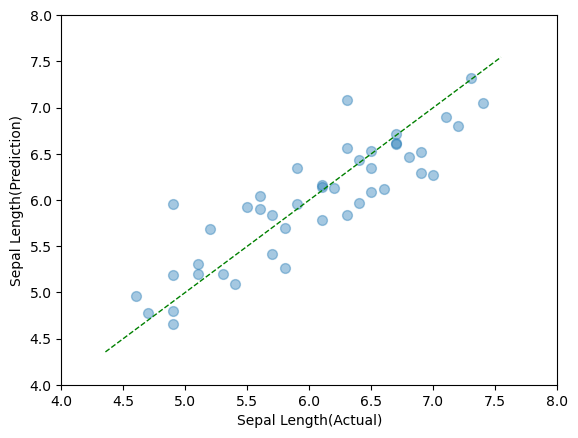

In [48]:
import matplotlib.pyplot as plt
import numpy as np


plt.scatter(iris_test["Sepal.Length"], np.fromstring(result[0], sep=","), alpha=0.4, s=50)
plt.xlabel("Sepal Length(Actual)")
plt.ylabel("Sepal Length(Prediction)")
x = np.linspace(*plt.xlim())
plt.plot(x, x, linestyle="--", color="g", linewidth=1)
plt.xlim(4, 8)
plt.ylim(4, 8)

plt.show()

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoint you created and avoid any charges from a stray instance being left on.

In [50]:
boto3.client("sagemaker").delete_endpoint(EndpointName=r_endpoint)

{'ResponseMetadata': {'RequestId': '3a470ceb-4ff4-42de-801d-244e7425b46d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3a470ceb-4ff4-42de-801d-244e7425b46d',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Wed, 11 Jan 2023 11:38:53 GMT'},
  'RetryAttempts': 0}}